In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pickle as pkl
import torch
from datetime import timedelta
from torch import nn
from torch.utils.data import TensorDataset,DataLoader
from river import preprocessing,compose

In [2]:
#path_log = "./TrainLog8Chunk/"
path_log = "./QarnotTraining/TrainLog/"
#path_log1h = "./TrainLog1H//"
chunkres = sorted([ele for ele in os.listdir(path_log) if not ele.startswith('.')])
#chunkres2 = sorted([ele for ele in os.listdir(path_log2) if not ele.startswith('.')])
#chunk1h = sorted([ele for ele in os.listdir(path_log1h) if not ele.startswith('.')])

In [3]:
def resultConcat(datapath, listchunk):
    trainloss = pd.DataFrame()
    validloss = pd.DataFrame()
    for chunk in listchunk:
        file_path = os.path.join(datapath, chunk)
        loss = os.path.join(file_path, "trainloss.csv")
        #valid = os.path.join(file_path, "validloss.csv")
        losspd = pd.read_csv(loss, header=None,names=["babbage","babyfoot","jacquard"])
        #validpd = pd.read_csv(valid, header=None,names=["babbage","babyfoot","jacquard"])
        losspd["chunk"] = chunk
        #validpd["chunk"]=chunk
        trainloss = pd.concat([trainloss, losspd]).reset_index(drop=True)
        #validloss = pd.concat([validloss,validpd]).reset_index(drop=True)
    return trainloss, validloss

In [4]:
def resultAvg(pdresult):
    res = pdresult.copy()
    res["maxloss"] = res[["babbage","babyfoot","jacquard"]].max(axis=1)
    res["iteration"] = pd.Series(np.arange(1, len(res)+1), res.index)
    res["totalloss_avgerr"]=res.maxloss.cumsum()/res.iteration
    res["bab_avgerr"]=res.babbage.cumsum()/res.iteration
    res["baby_avgerr"]=res.babyfoot.cumsum()/res.iteration
    res["jac_avgerr"]=res.jacquard.cumsum()/res.iteration
    return res

In [5]:
trainloss, validloss = resultConcat(path_log, chunkres)

In [6]:
trainloss = resultAvg(trainloss)

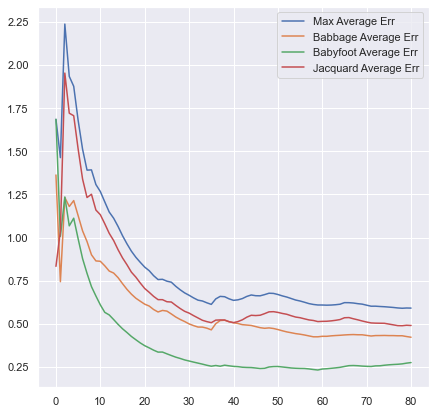

In [79]:
trainloss["totalloss_avgerr"][0:].plot(figsize=(7,7),label="Max Average Err")
trainloss["bab_avgerr"][0:].plot(label="Babbage Average Err")
trainloss["baby_avgerr"][0:].plot(label="Babyfoot Average Err")
trainloss["jac_avgerr"][0:].plot(label="Jacquard Average Err")
plt.legend()

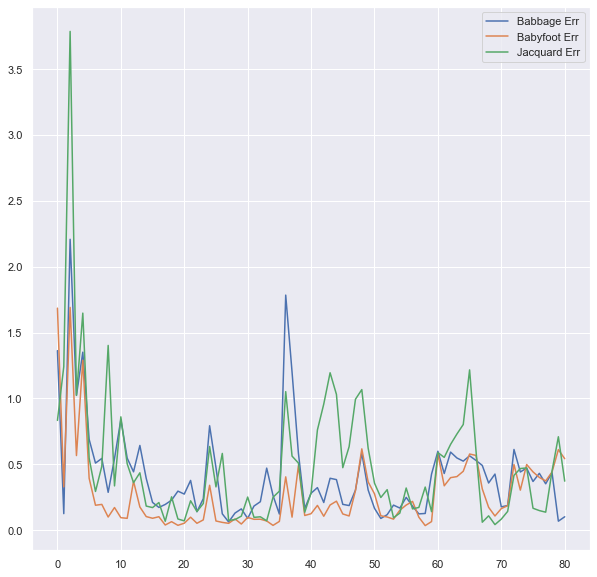

In [80]:
plt.figure(figsize=(10,10))
#trainloss["maxloss"].plot(figsize=(12,7),label="Max Err")
#trainloss["totalloss_avgerr"].plot(label="Max Average Err")
trainloss["babbage"][0:].plot(label="Babbage Err")
#trainloss["bab_avgerr"].plot(label="Babbage Average Err")
trainloss["babyfoot"][0:].plot(label="Babyfoot Err")
#trainloss["baby_avgerr"].plot(label="Babyfoot Average Err")
trainloss["jacquard"][0:].plot(label="Jacquard Err")
#trainloss["jac_avgerr"].plot(label="Jacquard Average Err")
plt.legend()
#plt.yscale("log")

In [226]:
def testcutoff(week,dataset):
    cutoff = dataset.index.max() - timedelta(weeks=week)
    trainidx = dataset.loc[dataset.index < cutoff]
    testidx = dataset.loc[dataset.index >= cutoff]
    return trainidx, testidx


def createXY(dataset, lookback, lookahead, lag, y_feature):
    data = dataset.values
    X, y = [], []
    for i in range(0,data.shape[0]-lookahead-lag,step=1):
        end_idx = i + lookback
        if (end_idx > data.shape[0]) or (end_idx+lag+lookahead > data.shape[0]):
            break
        data_feature = data[i:end_idx]
        data_target = dataset[y_feature][end_idx+lag:end_idx+lag+lookahead]
        data_target = data_target.values
        X.append(data_feature)
        y.append(data_target)
    return X,y

def toDataLoader(dataX, dataY, batch_size, window_len=4,smooth_=True):
    batch = len(dataX)
    timestepX = dataX[0].shape[0]
    timestepY = dataY[0].shape[0]
    features = dataX[0].shape[1]
    tensorX, tensorY = torch.empty((batch,timestepX,features)), torch.empty((batch,timestepY))
    for i,x,y in zip(range(batch),dataX,dataY):
        value = x
        recompense = x[:window_len]
        if smooth_:
            expSmooth = ExponentialSmoother(window_len=window_len,alpha=0.3)
            expSmooth.smooth(x.T)
            value = expSmooth.smooth_data.T
            value = np.concatenate([recompense,value],axis=0)

        transX = torch.tensor(value, dtype=torch.float32)
        transY = torch.tensor(y, dtype=torch.float32)

        tensorX[i,:] = transX
        tensorY[i,:] = transY

    datawrap = TensorDataset(tensorX,tensorY)
    loader = DataLoader(datawrap,batch_size=batch_size,drop_last=False)
    return loader

def assignWeight(model, state):
    with torch.no_grad():
        for (name,param),ele in zip(model.named_parameters(),state):
            param.copy_(nn.Parameter(ele))
    return model

def loadPickle(filepath):
    with open(filepath,"rb") as f:
        file = pkl.load(f)
    return file

def savePickle(filepath,obj):
    with open(filepath,"wb") as f:
        pkl.dump(obj, f)
        

class AutoEncoder(nn.Module):
    def __init__(self, input_size, output_encoder, time_step_in, time_step_out):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.output_encoder = output_encoder
        self.time_step_in = time_step_in
        self.time_step_out = time_step_out
        self.num_layers = 1

        self.encoder = nn.LSTM(self.input_size, self.output_encoder,
                               num_layers=self.num_layers, batch_first=True, bias=True)
        self.decoder = nn.LSTM(self.output_encoder,
                               self.output_encoder, batch_first=True)

        self.dropout = nn.Dropout(0.20)
        #self.batchnorm = nn.BatchNorm1d(self.time_step_in)

        self.LinearCombine = nn.Linear(
            self.input_size + self.output_encoder, 1, bias=False)

        self.linear = nn.Linear(
            self.time_step_in, self.time_step_out, bias=True)
        #self.linear2 = nn.Linear(
        #    self.time_step_out, self.time_step_out, bias=True)

    def forward(self,x):
        #---Encoder---#
        out_en,(h_en,_) = self.encoder(x)
        h_en = h_en.squeeze().unsqueeze(1)
        h_en = h_en.repeat(1,self.time_step_in,1)
        h_en = torch.tanh(h_en)

        #---Decoder---#
        out_de, (h_de,_) = self.decoder(h_en)
        out_de = self.dropout(out_de)

        #---Concatenate Input---#
        concat = torch.cat((out_de,x),dim=-1)
        concat = torch.tanh(concat)
        out = self.LinearCombine(concat)
        out = out.view(-1,self.time_step_in)
        #---MLP---#
        out = torch.sigmoid(out)
        out = self.dropout(out)
        out = self.linear(out)
        return out

In [227]:
lookback = 40
lookahead = 20
batch_size=20
lag = 0
cutoff=1

path_babbage = "./QarnotTraining/QarnotData/babbage/"
path_babyfoot = "./QarnotTraining/QarnotData/babyfoot/"
path_jacquard = "./QarnotTraining/QarnotData/jacquard/"
path_log = "./QarnotTraining/TrainLog/"
model_ini = AutoEncoder(5,30,lookback,lookahead)

In [228]:
def Loadfile(model,room_name,path_data,path_log, nb_chunk):
    if room_name == "babbage":
        nb_model = 0
    elif room_name=="babyfoot":
        nb_model = 1
    elif room_name=="jacquard":
        nb_model = 2
    list_chunk = sorted([f for f in os.listdir(path_data) if not f.startswith('.')])
    chunk_out = path_log + str(nb_chunk)+"Chunk/"
    model.load_state_dict(torch.load(chunk_out+"model_state_dict_"+str(nb_model)+".pt"))
    model.eval()
    scaler = loadPickle(chunk_out+"scalerX"+room_name+".pkl")
    
    data = pd.read_csv(path_data+list_chunk[nb_chunk], parse_dates=["time"],index_col=0)
    return model, scaler, data

def Prediction(model,scale,data,cutoff,lookback,lookahead,lag,y_feature,batch_size):
    _,valid = testcutoff(week=cutoff,dataset=data)
    valid = scaler.transform_many(valid)
    X, y = createXY(valid,lookback=lookback,lookahead=lookahead,lag=lag,y_feature=y_feature)
    loader = toDataLoader(X,y,batch_size,smooth_=False)
    
    outout = []
    truetrue = []
    for i,(x,y) in enumerate(loader):
        out = model(x)
        outout.append(out)
        truetrue.append(y)
    return outout,truetrue

In [245]:
model, scaler, data = Loadfile(model_ini,"babbage",path_babbage,path_log,5)
prediction, truevalue = Prediction(model, scaler, data, cutoff, lookback, lookahead, lag, "temperature",batch_size)

In [246]:
model_pred = np.array([prediction[i][0].detach().numpy() for i in range(9)]).flatten()
model_pred = model_pred*np.sqrt(scaler.vars["temperature"]) + scaler.means["temperature"]

truevalue = np.array([truevalue[i][0].detach().numpy() for i in range(9)]).flatten()
truevalue = truevalue*np.sqrt(scaler.vars["temperature"]) + scaler.means["temperature"]

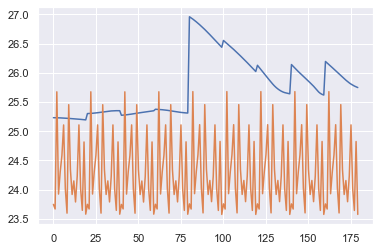

In [247]:
#plt.plot(model_pred)
plt.plot(truevalue)
plt.plot(model_pred)
#plt.yscale("log")